# Face Landmarks Detection with MediaPipe Tasks

This notebook shows you how to use MediaPipe Tasks Python API to detect face landmarks from images.

## Visualization utilities

In [11]:
# %%writefile helper_functions.py 
""" Some functions to visualize the face landmark detection results. """

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt


def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title("Face Blendshapes")
  plt.tight_layout()
  plt.show()

Writing helper_functions.py


## Download test image

Let's grab a test image that we'll use later. The image is from [Unsplash](https://unsplash.com/photos/mt2fyrdXxzk).

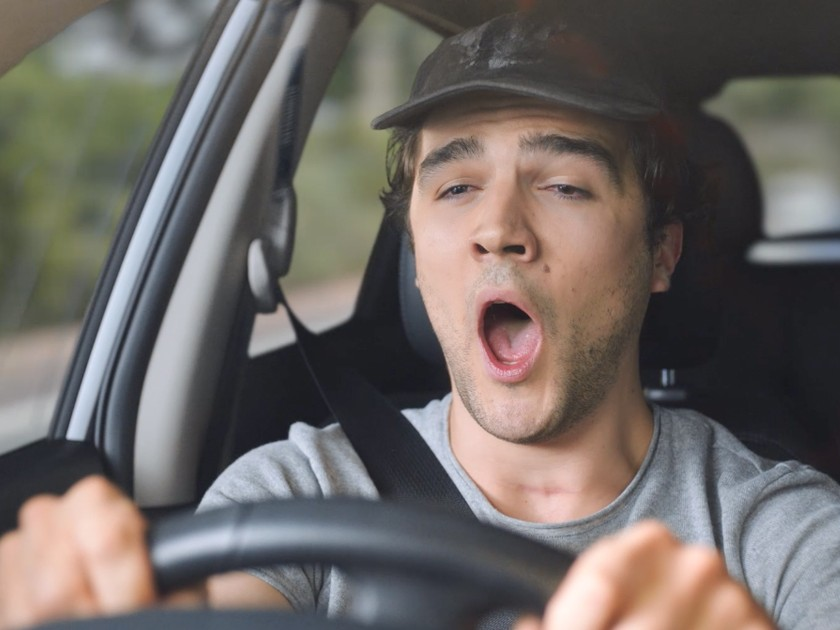

In [3]:
# import matplotlib.pyplot as plt
from IPython.display import Image, display
import cv2

display(Image(filename='../images/1200x630px-Regional2.jpg',width=640,height=400))


## Running inference and visualizing the results

Here are the steps to run face landmark detection using MediaPipe.

Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/face_landmarker/python) to learn more about configuration options that this task supports.


### See the link for [Configuration options](https://ai.google.dev/edge/mediapipe/solutions/vision/face_landmarker/python#configuration_options)


I0000 00:00:1728466329.174321 4840878 gl_context.cc:357] GL version: 2.1 (2.1 ATI-5.5.17), renderer: AMD Radeon Pro 560X OpenGL Engine
W0000 00:00:1728466329.174750 4840878 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
W0000 00:00:1728466329.185826 4843922 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1728466329.202159 4843924 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


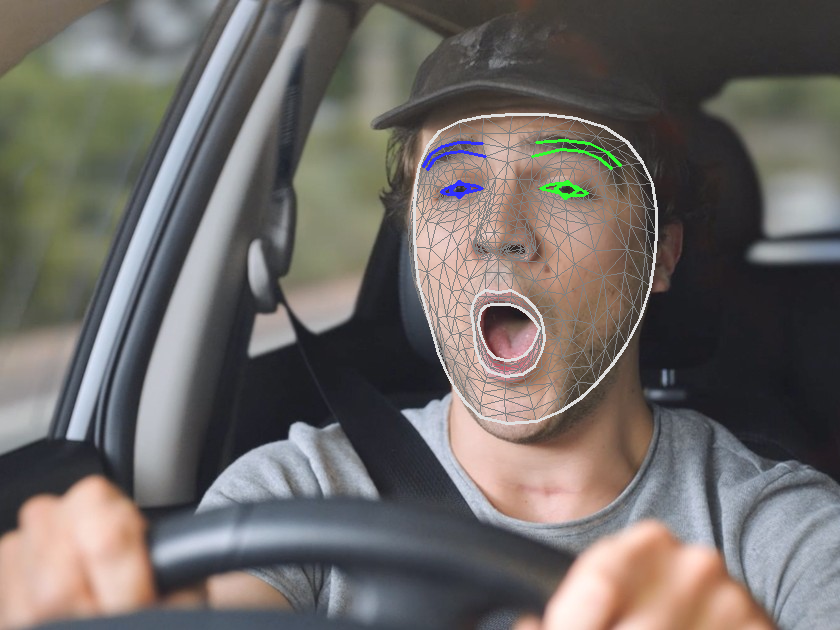

In [5]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='../model/face_landmarker.task')

# Setting up the task
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
                                    #    ) running_mode = vision.RunningMode.LIVE_STREAM

# The MediaPipe Face Landmarker task uses the create_from_options function to set up the task. 
detector = vision.FaceLandmarker.create_from_options(options)


# STEP 3: Load the input image. Creates `Image` object from the image file.
image = mp.Image.create_from_file("../images/1200x630px-Regional2.jpg")

# STEP 4: Detect face landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view()[:,:,:3], detection_result)

cv2.imwrite('../images/ann_image.png',cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

display(Image(filename='../images/ann_image.png'))




We will also visualize the face blendshapes categories using a bar graph.

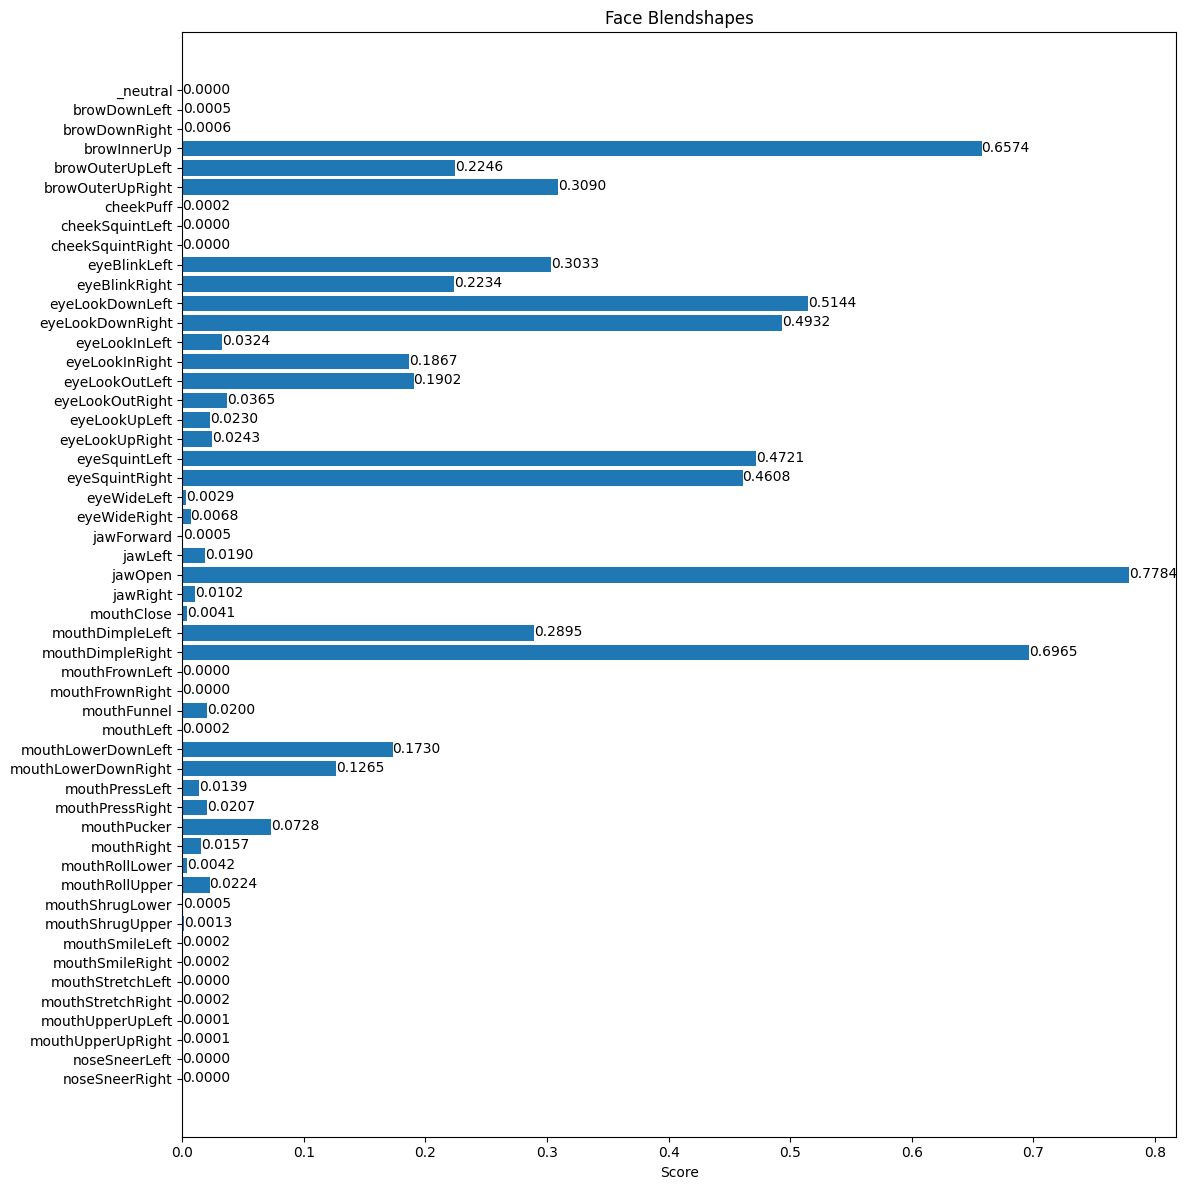

In [6]:
plot_face_blendshapes_bar_graph(detection_result.face_blendshapes[0])

And print the transformation matrix.

In [9]:
print("Facial transformation matrix:\n",np.array(detection_result.facial_transformation_matrixes[0].data))

Facial transformation matrix:
 [[ 9.67280030e-01  3.36711444e-02 -2.51467764e-01  6.23411226e+00]
 [-7.46598933e-03  9.94503140e-01  1.04443550e-01  4.21152735e+00]
 [ 2.53602117e-01 -9.91485789e-02  9.62214053e-01 -3.36438293e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [10]:
len(detection_result.face_landmarks[0])

478

In [12]:
detection_result.face_landmarks[0]

[NormalizedLandmark(x=0.5929028391838074, y=0.46415019035339355, z=-0.046623602509498596, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.5893384218215942, y=0.38431474566459656, z=-0.07102516293525696, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.5934350490570068, y=0.4121090769767761, z=-0.04288092255592346, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.5844557881355286, y=0.33912256360054016, z=-0.045293357223272324, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.5891698598861694, y=0.36834099888801575, z=-0.07337739318609238, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.5912829637527466, y=0.35030606389045715, z=-0.06580188870429993, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.5994077920913696, y=0.3067486882209778, z=-0.02444547973573208, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.5294253826141357, y=0.3078577518463135, z=0.04220578819513321, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.6036345362663269, 

In [13]:
detection_result.face_landmarks[0][1]

NormalizedLandmark(x=0.5893384218215942, y=0.38431474566459656, z=-0.07102516293525696, visibility=0.0, presence=0.0)

In [14]:
detection_result.facial_transformation_matrixes

[array([[ 9.67280030e-01,  3.36711444e-02, -2.51467764e-01,
          6.23411226e+00],
        [-7.46598933e-03,  9.94503140e-01,  1.04443550e-01,
          4.21152735e+00],
        [ 2.53602117e-01, -9.91485789e-02,  9.62214053e-01,
         -3.36438293e+01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]])]

# **Eye aspect ratio (EAR)**

In [15]:
def find_xyz (detected_point):
  '''
  To access class object values
  '''

  return np.array((detected_point.x , detected_point.y , detected_point.z))


In [26]:
def distance(point1, point2):
  '''
  Euclidean distance finder
  '''
  return np.linalg.norm(point1 - point2)


In [63]:
face_landmarks = detection_result.face_landmarks[0]

EAR_r =   distance (find_xyz(face_landmarks[160]) , find_xyz(face_landmarks[144]))+\
        distance (find_xyz(face_landmarks[158]) , find_xyz(face_landmarks[153])) /\
    2 * distance (find_xyz(face_landmarks[33])  , find_xyz(face_landmarks[133]))
print('EAR for right eye is :', EAR_r)

EAR for right eye is : 0.013396174963024607


In [64]:
face_landmarks = detection_result.face_landmarks[0]

EAR_l =   distance (find_xyz(face_landmarks[385]) , find_xyz(face_landmarks[380]))+\
        distance (find_xyz(face_landmarks[386]) , find_xyz(face_landmarks[373])) /\
    2 * distance (find_xyz(face_landmarks[463])  , find_xyz(face_landmarks[263]))
print('EAR for left eye is :', EAR_l)

EAR for left eye is : 0.015214603211457362


In [65]:
EAR = (EAR_l+EAR_r)/2
print('Total EAR is :', EAR)

Total EAR is : 0.014305389087240983


$$
T_{\text{H range}} =
\begin{cases}
    \text{Active} & \text{if } \text{EAR} \geq 0.28 \\
    \text{Fatigue} & \text{if } 0.17 < \text{EAR} \leq 0.27 \\
    \text{Sleep} & \text{if } \text{EAR} \leq 0.17
\end{cases}
$$


In [ ]:
Minimum_EAR :bool = 0.01
eye_closed : bool = False

if EAR > Minimum_EAR:
  print('Driver state: AWARE')
else:
  eye_closed : bool = True
  print('E')

Driver state: AWARE


# **Blinking frequency**

Normally, driver will blink 10 to 25 times per minute on average, while in a fatigue state, the
number of blinks will increase. Blink frequency can be judged by EAR. Set the threshold as α nd the
number of frames as n, we count the number N of consecutive frames when EAR<α.
# **Perclos**

The percentage of human
eye closure time in the total time within a time period  

In [68]:
Minimum_EAR           : bool = 0.01 # To consider eye state as open
blink_frame_num       : int  = 10 # MAX number of consequative frames with eye state = close to be considered as a blink
closed_eye_frame_th   : int  = 25 # MIN number of consequative frames needed to recognize eye state as closed
total_frame_count     : int = 0
eye_closed            : bool = False
blinking_counter      : int = 0
blinking_threshold    : int = 40 # The number of blinking for a normal person per minute
closed_eye_frame_count: int = 0

# for frame in frames:
total_frame_count += 1

# Determining if eyes are closed ?
if EAR < Minimum_EAR:
  closed_eye_frame_count += 1
print('Eyes are open')

perclos = (closed_eye_frame_count/total_frame_count) * 100

if closed_eye_frame_count <= blink_frame_num :
  blinking_counter += 1

blinking_frequency = blinking_counter / total_frame_count

if closed_eye_frame_count >= closed_eye_frame_th or perclos > 80:
  eye_closed = True

if blinking_counter > blinking_threshold:
  print('Blinking frequency more than normal state. Possibility for fatigue state!')

elif eye_closed:
  print('Eyes are closed! Driver state is FATIGUE. DANGER!!')
  # eye_closed = False

Eyes are open


# **Mouth aspect ratio (MAR)**

In [69]:
MAR =  distance (find_xyz(face_landmarks[37]) , find_xyz(face_landmarks[84]))+\
       distance (find_xyz(face_landmarks[267]), find_xyz(face_landmarks[314]))/\
   2 * distance (find_xyz(face_landmarks[67]) , find_xyz(face_landmarks[292]))
print('MAR is:', MAR)

MAR is: 0.15544165209923785


# **Yawning state and frequency detection**

In [74]:
closed_MAR        : float = 0.03 # below this value mouth is considered as closed
yawning_threshold : float = 0.06
yawning_frequecy  : float = 0.0

n_yawning_frames = {'min':10 , 'max':30} # Required number of consequent frames with yawning state = True to detect fatigue state. This needs to be adjusted baed on camera Frame rate

yawning_state   : bool = False
fatigue_state   : bool = False
yawning_counter : int = 0 # counts the number of frames with yawning state = True

# while True:

  # for frame in image_frames:
  # get the MAR value

if MAR <= closed_MAR: # mouth is closed
  yawning_state = False
  print('mouth is closed')

elif MAR > closed_MAR and MAR < yawning_threshold: # mouth recognized as open, speaking state

  yawning_state = False
  print('mouth recognized as open, speaking state')

elif MAR > yawning_threshold: # yawning detected
  yawning_state =  True
  print('Yawning detected')

if yawning_state:
  yawning_counter += 1
  yawning_state = False


if yawning_counter > n_yawning_frames['min'] and yawning_counter < n_yawning_frames['max']:
  fatigue_state = True
  yawning_frequecy += yawning_counter
  yawning_counter = 0

  # TO DO : there needs to be some condition under which we will reset the fatigue_state flag to False
  # TO DO : Calculate yawning frequency based on the choosen time period


Yawning detected


# **HEAD EULER ANGELS**

In [96]:
Rotation_matrix = np.array(detection_result.facial_transformation_matrixes[0].data)[:3,:3]
print(Rotation_matrix)

[[ 0.96728003  0.03367114 -0.25146776]
 [-0.00746599  0.99450314  0.10444355]
 [ 0.25360212 -0.09914858  0.96221405]]


In [110]:
rad2degree = lambda x: x * (180/np.pi)

roll = np.arctan2(Rotation_matrix[2,0],Rotation_matrix[2,1])
pitch = np.arccos(Rotation_matrix[2,2])
yaw = - np.arctan2(Rotation_matrix[0,2],Rotation_matrix[1,2])

print('Roll :', rad2degree(roll))
print('Pitch :', rad2degree(pitch))
print('Yaw :', rad2degree(yaw) )

Roll : 111.35356827945236
Pitch : 15.800829250094495
Yaw : 67.44514165665161


In [ ]:
roll_threshold = {'min': -41, 'max': 36.3}
pitch_threshold = {'min': -60.4, 'max': 69.6}
yaw_threshold = {'min': -75, 'max': 75}



In [107]:
roll = np.arctan2(Rotation_matrix[2,1],Rotation_matrix[2,2])
pitch = np.arctan2(-Rotation_matrix[2,0],np.sqrt((Rotation_matrix[2,1])**2 + (Rotation_matrix[2,2])**2))
yaw = - np.arctan2(Rotation_matrix[1,0],Rotation_matrix[0,0])
print('Roll :', roll * (180/np.pi))
print('Pitch :', pitch * (180/np.pi))
print('Yaw :', yaw * (180/np.pi))

Roll : -0.1026797395967108
Pitch : -14.690767131147002
Yaw : 0.4422309677114803
